# Etivity Assignment 1: Ships in Satellite Imagery
In this assignment we will build & train an object detector to solve the problem of idenifying ships in satellite imagery. 

![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/sat_img1.JPG?raw=true)

This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution. 



This lab uses a [kaggle dataset](https://www.kaggle.com/rhammell/ships-in-satellite-imagery). Please read the [PDF](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab.  The dataset contains image patches of ships as well as background images of sea and coastline. 

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)

This assigment contains all the code necessary to read the downloaded kaggle files and create image and label arrays with test and train splits.




# Dowload Kaggle Dataset.
The following code cells will download the kaggle ship-in-satellite-imagery dataset and unzip the file. (Ensure you have a valid kaggle API token stored on your PC as described in the PDF.)

In [1]:
! pip install -q kaggle==1.5.6

images_path = ''
main_img_path = 'scenes/scenes/sfbay_3.png'
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import files
    files.upload()

Saving kaggle.json to kaggle (12).json


In [2]:
# Use this only if have problems with stale .json file
#!rm kaggle.json
#!rm ~/.kaggle/kaggle.*

In [3]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
! kaggle datasets download rhammell/ships-in-satellite-imagery

!unzip ships-in-satellite-imagery.zip > /dev/null

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ships-in-satellite-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)
replace scenes/scenes/lb_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#HouseKeeping
 Import packages, helper functions to read from URL and import images.

In [4]:
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import glob
import urllib.request
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy import signal
import json

# Classifiers
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

def url_to_image(url):
  	resp = urllib.request.urlopen(url)
  	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
  	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
  	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
  	return temp_image

def read_image(image_url):
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Image is scaled to reduce computation time
    image = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    return image

In [5]:
# Read downloaded file list: Files are comprised of positive (ship) and negaitive (Not ship) examples

pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')
print(np.shape(pos_img_list))

(1000,)


# Read Data 
Read data from unzipped downloaded files and create the Training and Test sets. (Note that these are training and test sets of image patches that can be used to train an image classifier)

In [6]:
# Set variables
n = 80 # number of x,y pixels in this image.
n_pts = 4000 # number of points to use (are 4000 in dataset, 1000 positive 3000 negative)

In [7]:
def read_images(img_list):
   train_pos = np.empty([1,n*n])
   # Function to read images from file list 
   for i in range(len(img_list)): 
      img_path = img_list[i]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #  store image as row in array
      train_pos = (np.concatenate((train_pos,np.reshape(img, (1, n*n)))) if i>0 else  np.reshape(img, (1, n*n)))
   return train_pos 

In [8]:
# Read positive and negative ship images into arrays 
pos_img = read_images(pos_img_list)
neg_img = read_images(neg_img_list)

Text(0.5, 1.0, 'Extension mode: mirror')

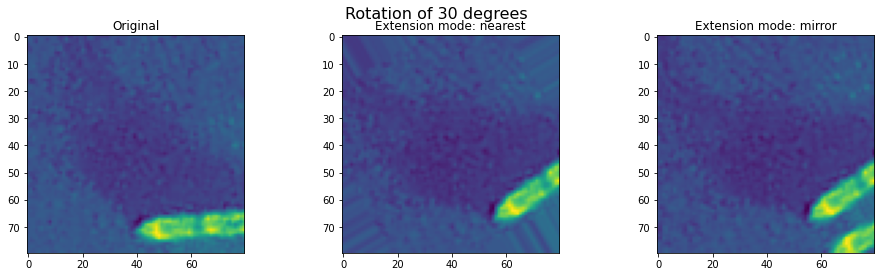

In [9]:
from scipy.ndimage import rotate
neg_img_aug_nearest = rotate(np.reshape(neg_img[0], (n, n)), 30, reshape=False, mode='nearest')
neg_img_aug_mirror = rotate(np.reshape(neg_img[0], (n, n)), 30, reshape=False, mode='mirror')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
fig.suptitle('Rotation of 30 degrees', size=16)
ax[0].imshow(np.reshape(neg_img[0], (n, n)))
ax[0].set_title('Original')
ax[1].imshow(neg_img_aug_nearest)
ax[1].set_title('Extension mode: nearest')
ax[2].imshow(neg_img_aug_mirror)
ax[2].set_title('Extension mode: mirror')

In [10]:
 import random
 AUGMENT_CNT = 3000

aug_imgs = []
random.seed(42)
for idx in range(AUGMENT_CNT):
    angle = random.randint(10, 170)
    aug_imgs.append(rotate(np.reshape(neg_img[idx], (n, n)), angle, reshape=False, mode='mirror'))
    
aug_imgs = np.asarray(aug_imgs)
aug_imgs.shape 

(3000, 80, 80)

In [11]:
aug_imgs = aug_imgs.reshape(AUGMENT_CNT, 6400)

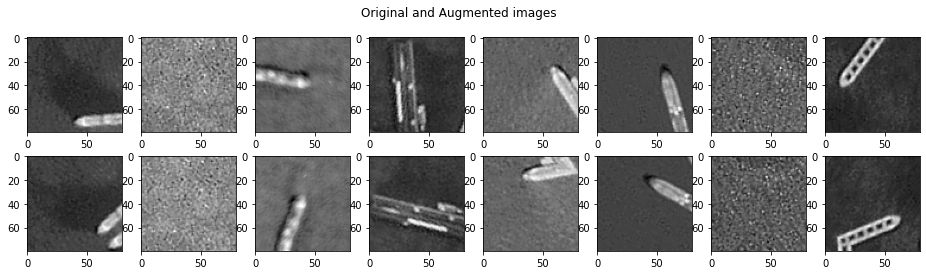

In [12]:
imgs_per_row = 8
fig, ax = plt.subplots(nrows=2, ncols=imgs_per_row, figsize=(16,4))
fig.suptitle('Original and Augmented images')
for idx in range(imgs_per_row):
    ax[0][idx].imshow(np.reshape(neg_img[idx], (n, n)), 'gray')
    ax[1][idx].imshow(np.reshape(aug_imgs[idx], (n, n)), 'gray')

In [13]:
neg_img.shape

(3000, 6400)

In [14]:
aug_imgs.shape

(3000, 6400)

In [15]:
neg_img = np.append(neg_img, aug_imgs, axis=0)
neg_img.shape 

(6000, 6400)

In [16]:
# create corresponding arrays of labels
y_pos_labels = np.ones(len(pos_img_list))
y_neg_labels = np.zeros(len(neg_img_list) + AUGMENT_CNT)

In [17]:
# Combine positive and negative images into one dataset. 
dataset_img = np.concatenate((pos_img[0:1000,:],neg_img[0:3000+AUGMENT_CNT,:]))
dataset_labels = np.append(y_pos_labels,y_neg_labels)

In [18]:
# Training examples
n_train = int(0.7*(n_pts+AUGMENT_CNT))

# Divide into training and test sets with labels
X_train, X_test, y_train, y_test = train_test_split(dataset_img, dataset_labels, train_size=n_train,
                                                    random_state=0,
                                                    stratify=dataset_labels)

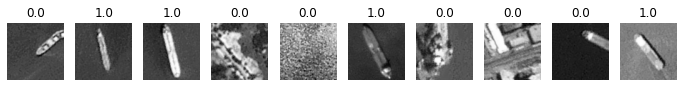

In [19]:
# Plot some examples from the training data
n_plots = 10 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(12,20))
for i in range(0,n_plots,1):

   axarr[i].imshow( np.reshape(X_train[i,0:n*n], (n, n)) ,'gray')
   axarr[i].axis('off')
   axarr[i].title.set_text(y_train[i])

#Part 2. Build and Train an Image Classifier
As we have seen in the notes simple object detectors are based on image classifiers trained on image patches. You must choose an appropriate representation for the images and a suitable classifier.

Hints:
> `feature.hog` command from [skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). 

>sklearn [list of classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)



## Your Work Here......
You can write code to train and test your image classifier in the code cell(s) below:

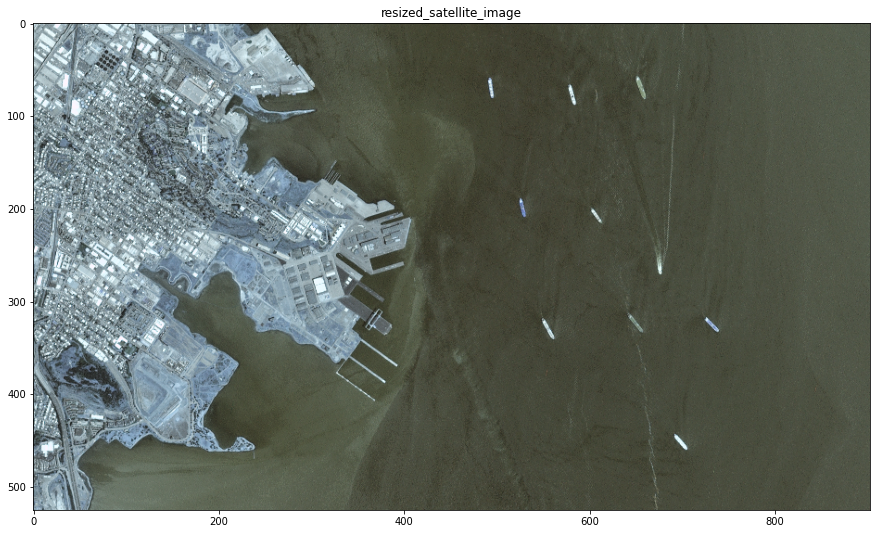

In [20]:
satellite_image = cv2.imread(main_img_path, cv2.IMREAD_COLOR)
scale_factor = 3

# Resize image if required.
test_size = np.shape(satellite_image)
resized_satellite_image = cv2.resize(satellite_image,
                        dsize=(int(test_size[1]/scale_factor),
                               int(test_size[0]/scale_factor)),
                        interpolation=cv2.INTER_CUBIC)

# Plot Test Image
plt.figure(figsize=(15,20))
plt.title('resized_satellite_image')
plt.imshow(resized_satellite_image)

In [21]:
# Load data
with open('/content/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head() 

data  ...             scene_ids
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...  ...  20180708_180909_0f47
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...  ...  20170705_180816_103e
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...  ...  20180712_211331_0f06
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...  ...  20170609_180756_103a
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...  ...  20170515_180653_1007

[5 rows x 4 columns]

In [22]:
# Size of the training and test datasets
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))
print('Positive and negative images dataset sizes: \n{}'.format(dataset_img.shape))

Training data and target sizes: 
(4900, 6400), (4900,)
Test data and target sizes: 
(2100, 6400), (2100,)
Positive and negative images dataset sizes: 
(7000, 6400)


In [23]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of ship_images :{}".format(ship_images),"\n")
print("Number of no_ship_images :{}".format(no_ship_images))

Number of ship_images :3000 

Number of no_ship_images :1000


In [24]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [25]:
x.shape

(4000, 19200)

In [26]:
x_reshaped = x.reshape([-1, 3, 80, 80])
x_reshaped.shape

(4000, 3, 80, 80)

In [27]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [28]:
y.shape

(4000,)

In [29]:
# Extract & reshape image data and labels from dataset

## Images
img_length = 80 # number of x,y pixels in this image
data = np.array(dataset['data']).astype('uint8')
data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])

## Labels 
labels = np.array(dataset['labels']).reshape(len(dataset['labels']),1)

Sample instances from dataset


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1]')

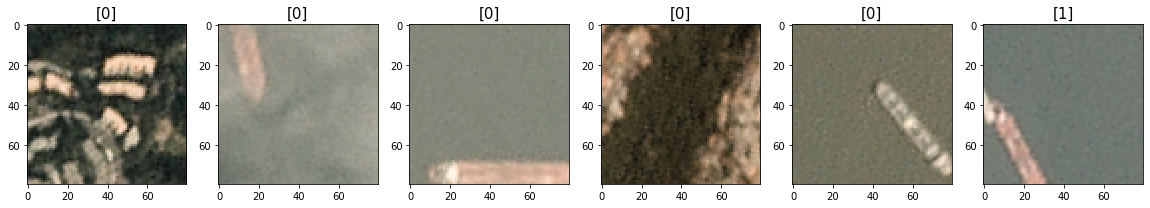

In [30]:
# Random sample
from numpy import random

x=random.randint(len(data), size=(6)) # 6 random numbers

print("Sample instances from dataset")
f, axarr = plt.subplots(1,6,figsize=(20,20))
axarr[0].imshow(data[x[0]])
axarr[0].set_title(labels[x[0]],fontsize =15)
axarr[1].imshow(data[x[1]])
axarr[1].set_title(labels[x[1]],fontsize =15)
axarr[2].imshow(data[x[2]])
axarr[2].set_title(labels[x[2]],fontsize =15)
axarr[3].imshow(data[x[3]])
axarr[3].set_title(labels[x[3]],fontsize =15)
axarr[4].imshow(data[x[4]])
axarr[4].set_title(labels[x[4]],fontsize =15)
axarr[5].imshow(data[x[5]])
axarr[5].set_title(labels[5],fontsize =15)

In [31]:
# Check shapes
print("data:", data.shape)
print("labels:", labels.shape)

data: (4000, 80, 80, 3)
labels: (4000, 1)


In [32]:
 # Convert data into greyscale
from skimage import color,img_as_float

data_gray = [color.rgb2gray(i) for i in data]

# Extract HOG features
# Parameters
ppc = [12,12] # pixels per cell
block_size = [3,3] # Cells per block

# Loop
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc),cells_per_block=(block_size),block_norm='L2-Hys',visualize=True, transform_sqrt=False,feature_vector=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

Text(0.5, 1.0, 'Hog features')

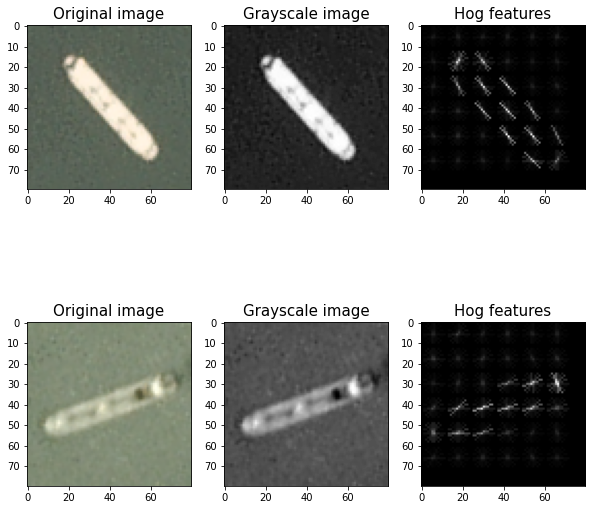

In [33]:
# Sample of HOG features

f, axarr = plt.subplots(2,3,figsize=(10,10))
axarr[0][0].imshow(data[0])
axarr[0][0].set_title("Original image",fontsize =15)
axarr[0][1].imshow(data_gray[0],'gray')
axarr[0][1].set_title("Grayscale image",fontsize =15)
axarr[0][2].imshow(hog_images[0],'gray')
axarr[0][2].set_title("Hog features",fontsize =15)

axarr[1][0].imshow(data[2])
axarr[1][0].set_title("Original image",fontsize =15)
axarr[1][1].imshow(data_gray[2],'gray')
axarr[1][1].set_title("Grayscale image",fontsize =15)
axarr[1][2].imshow(hog_images[2],'gray')
axarr[1][2].set_title("Hog features",fontsize =15)

In [34]:
#Create a SVM classifier
clf = svm.SVC()

hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels))

#Shuffle the data set
np.random.shuffle(data_frame)
percentage = 70
partition = int(len(hog_features)*percentage/100)
x_train = data_frame[:partition,:-1]
x_test  = data_frame[partition:,:-1]
y_train = data_frame[:partition,-1:].ravel() 
y_test = data_frame[partition:,-1:].ravel()

#Train the classifier with the training data
clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
 # Predict 
from sklearn.metrics import classification_report,accuracy_score
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

Accuracy: 0.9908333333333333


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       882
         1.0       0.98      0.99      0.98       318

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



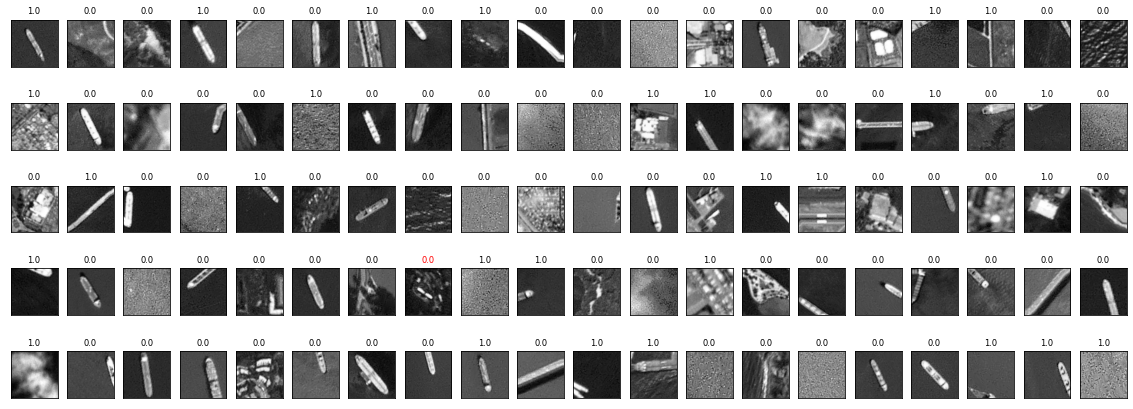

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

def plot_examples(y_pred,y_test):
   n_plots = 30 # number of plots
   fig = plt.figure(figsize=(20, 15))
   for i in range(100):
      ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
      ax.imshow( np.reshape(X_test[i,0:n*n], (n, n)) ,'gray')
      color = ('black' if y_pred[i] == y_test[i] else 'red')
      ax.set_title(y_test[i],
                 fontsize='small', color=color)
      
plot_examples(y_pred,y_test)

#2. Use the Classifier as a basic Object Detector

Test performance of your classifier using the test dataset and obtain a [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).

You can plot some examples from the test set using the function in the cell below.  

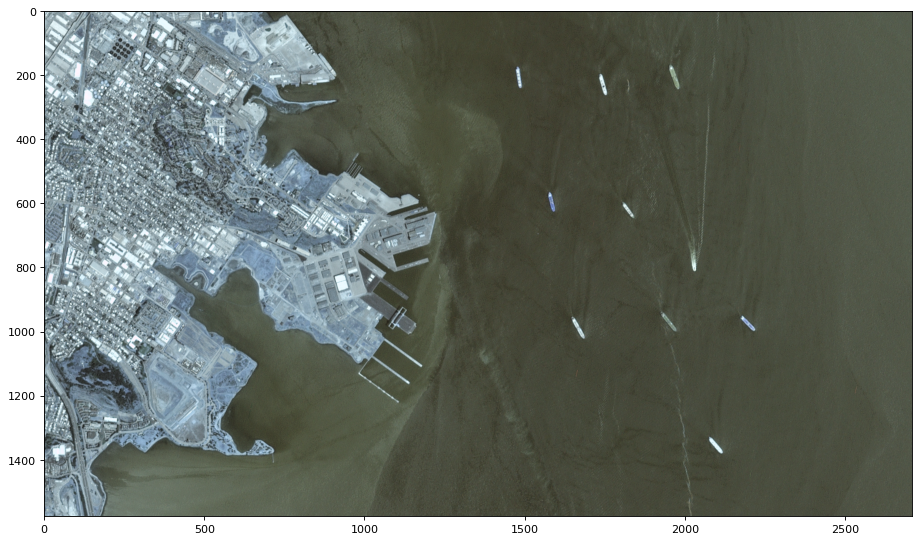

In [37]:
# Load and Display Secene to perform Object Detection on
img_path = 'scenes/scenes/sfbay_3.png'
col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.imshow( col_img ,'gray')

In [38]:
from PIL import Image, ImageEnhance
from numpy import asarray

class MakePatches:
    def __init__(self, img, patch_size, stride):
        self.img = img
        self.size = patch_size
        self.stride = stride
        self.image_width, self.image_height = img.size
        self.num_cols = self.image_width // self.stride
        self.num_rows = self.image_height // self.stride

    def extract_patches(self):
        return [self.extract_patch((w, h)) for h in range(self.num_rows) for w in range(self.num_cols)]
        
    def extract_patch(self, patch):
        left = patch[0] * self.stride
        top = patch[1] * self.stride
        right = patch[0] * self.stride + self.size
        bottom = patch[1] * self.stride + self.size
        this_img = self.img.crop((
            left,
            top,
            right,
            bottom
        ))
        return [this_img, left, top, right, bottom]

def get_coordinates(predictions):
  """get coordinate of positive predictions (ships)"""
  positive = []

  for obj in predictions:
      if obj[0]==1:
          data = np.array([obj[1],obj[2],obj[3],obj[4]], dtype=np.float32)
          positive.append(data)
  return np.array(positive)

In [39]:
 #Load the scene image and convert to greyscale (1 channel)
scene_image = Image.open('scenes/scenes/sfbay_3.png').convert('L')

In [40]:
# Patches must be 80x80 to match the image sizes used to train the SVM detector

# Variables 
img_size = 80
stride = 20

mp = MakePatches(Image.open(img_path).convert('L'),img_size,stride)
patch_list = mp.extract_patches()
print("Number of patches:", len(patch_list))

Number of patches: 10530


Text(0.5, 1.0, '2nd Patch Image - Stride = 20')

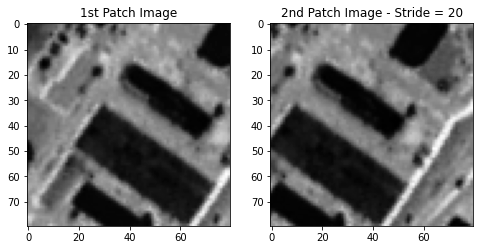

In [41]:
 #Print sample patches
# Create Plots
f, axarr = plt.subplots(1,2,figsize=(8,8))
axarr[0].imshow(patch_list[0][0],"Greys")
axarr[0].set_title('1st Patch Image',fontsize =12)
axarr[1].imshow(patch_list[1][0],"Greys")
axarr[1].set_title('2nd Patch Image - Stride = '+str(stride),fontsize =12)

In [42]:
# Scan the image for ships

output = []
p = []

for patch in patch_list:
    
    # Get the HOG features
    fd = hog(patch[0], orientations=9, pixels_per_cell=(ppc),cells_per_block=(block_size),block_norm='L2-Hys',visualize=False, transform_sqrt=False,feature_vector=True).reshape(1, -1)
    
    # Predict on the patches
    pred = clf.predict(fd)
    result = [pred,patch[1],patch[2],patch[3],patch[4]]
    
    # Save the results
    output.append(result)

# Get list of positive results (ships) as found_boxes
found_boxes = get_coordinates(output)

Before suppression, we had 21 bounding boxes, after suppression we have 16


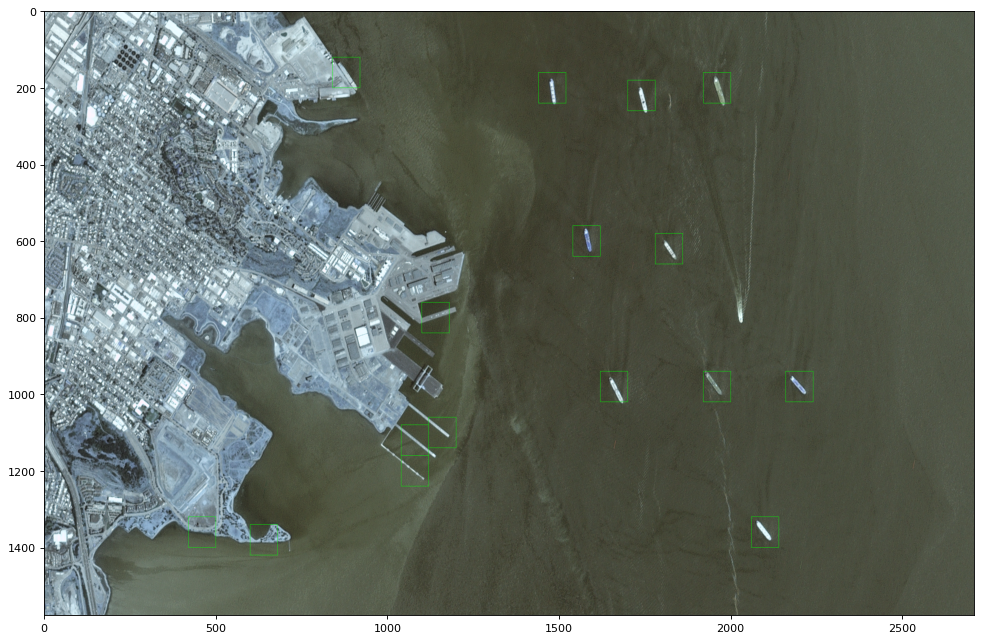

In [43]:
from imutils.object_detection import non_max_suppression

#Bounding box parameters
greenColor = (0, 255, 0)
lineThickness = 4

# run non-max suppression on these based on an overlay of 65%
nmsBoundingBoxes = non_max_suppression(found_boxes, probs=None, overlapThresh=0.1)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(found_boxes), len(nmsBoundingBoxes)))

greenColor = (0, 255, 0)
lineThickness = 1
# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(col_img, (xA, yA), (xB, yB), greenColor, lineThickness)

# Plot figures
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.show()